In [63]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Analysis of Zero shot accuracies for each prompt

In [11]:
path = "/nethome/bdevnani3/flash1/long_tail_lang/scripts/prompt_strength_checker_output.json"
f = open(path)
imps = json.load(f)
print(imps)

{'{}': {'test_all': 0.5527, 'test_many': 0.5640519480519481, 'test_median': 0.5452192066805844, 'test_low': 0.5469117647058823, 'test_fscore': 0.5380920033632163, 'test_precision': 0.5782957230389296}, 'a photo of a {}.': {'test_all': 0.58172, 'test_many': 0.5938701298701299, 'test_median': 0.5738204592901879, 'test_low': 0.5751470588235295, 'test_fscore': 0.5750657724811106, 'test_precision': 0.6142515220259199}, 'a bad photo of a {}.': {'test_all': 0.5905, 'test_many': 0.6008311688311688, 'test_median': 0.5841753653444677, 'test_low': 0.583529411764706, 'test_fscore': 0.5825683678689408, 'test_precision': 0.6144089195158681}, 'a photo of many {}.': {'test_all': 0.5725, 'test_many': 0.587012987012987, 'test_median': 0.5637578288100208, 'test_low': 0.5622058823529411, 'test_fscore': 0.5665055110089818, 'test_precision': 0.6034345110842073}, 'a sculpture of a {}.': {'test_all': 0.53238, 'test_many': 0.5462337662337663, 'test_median': 0.5266388308977036, 'test_low': 0.5133823529411764, '

In [25]:
df = pd.DataFrame.from_dict(imps, orient='index').reset_index()
df = df.sort_values(by=['test_all'])
df

,index,test_all,test_many,test_median,test_low,test_fscore,test_precision
45,a origami {}.,0.49082,0.503896,0.490230,0.455882,0.477100,0.568005
72,the plushie {}.,0.49098,0.505351,0.487098,0.463971,0.468737,0.543259
41,the origami {}.,0.49188,0.503377,0.488727,0.470441,0.473134,0.553868
63,a plushie {}.,0.49328,0.512104,0.488309,0.457500,0.473917,0.555115
75,graffiti of the {}.,0.49830,0.516052,0.488225,0.483529,0.476742,0.534762
...,...,...,...,...,...,...,...
21,a photo of the cool {}.,0.59258,0.601299,0.584885,0.595000,0.584870,0.611001
78,a photo of a cool {}.,0.59314,0.603377,0.584468,0.594706,0.586280,0.615407
62,a good photo of a {}.,0.59432,0.601506,0.587015,0.599706,0.587687,0.615471
64,a photo of the nice {}.,0.59432,0.604260,0.586848,0.592500,0.586824,0.610373


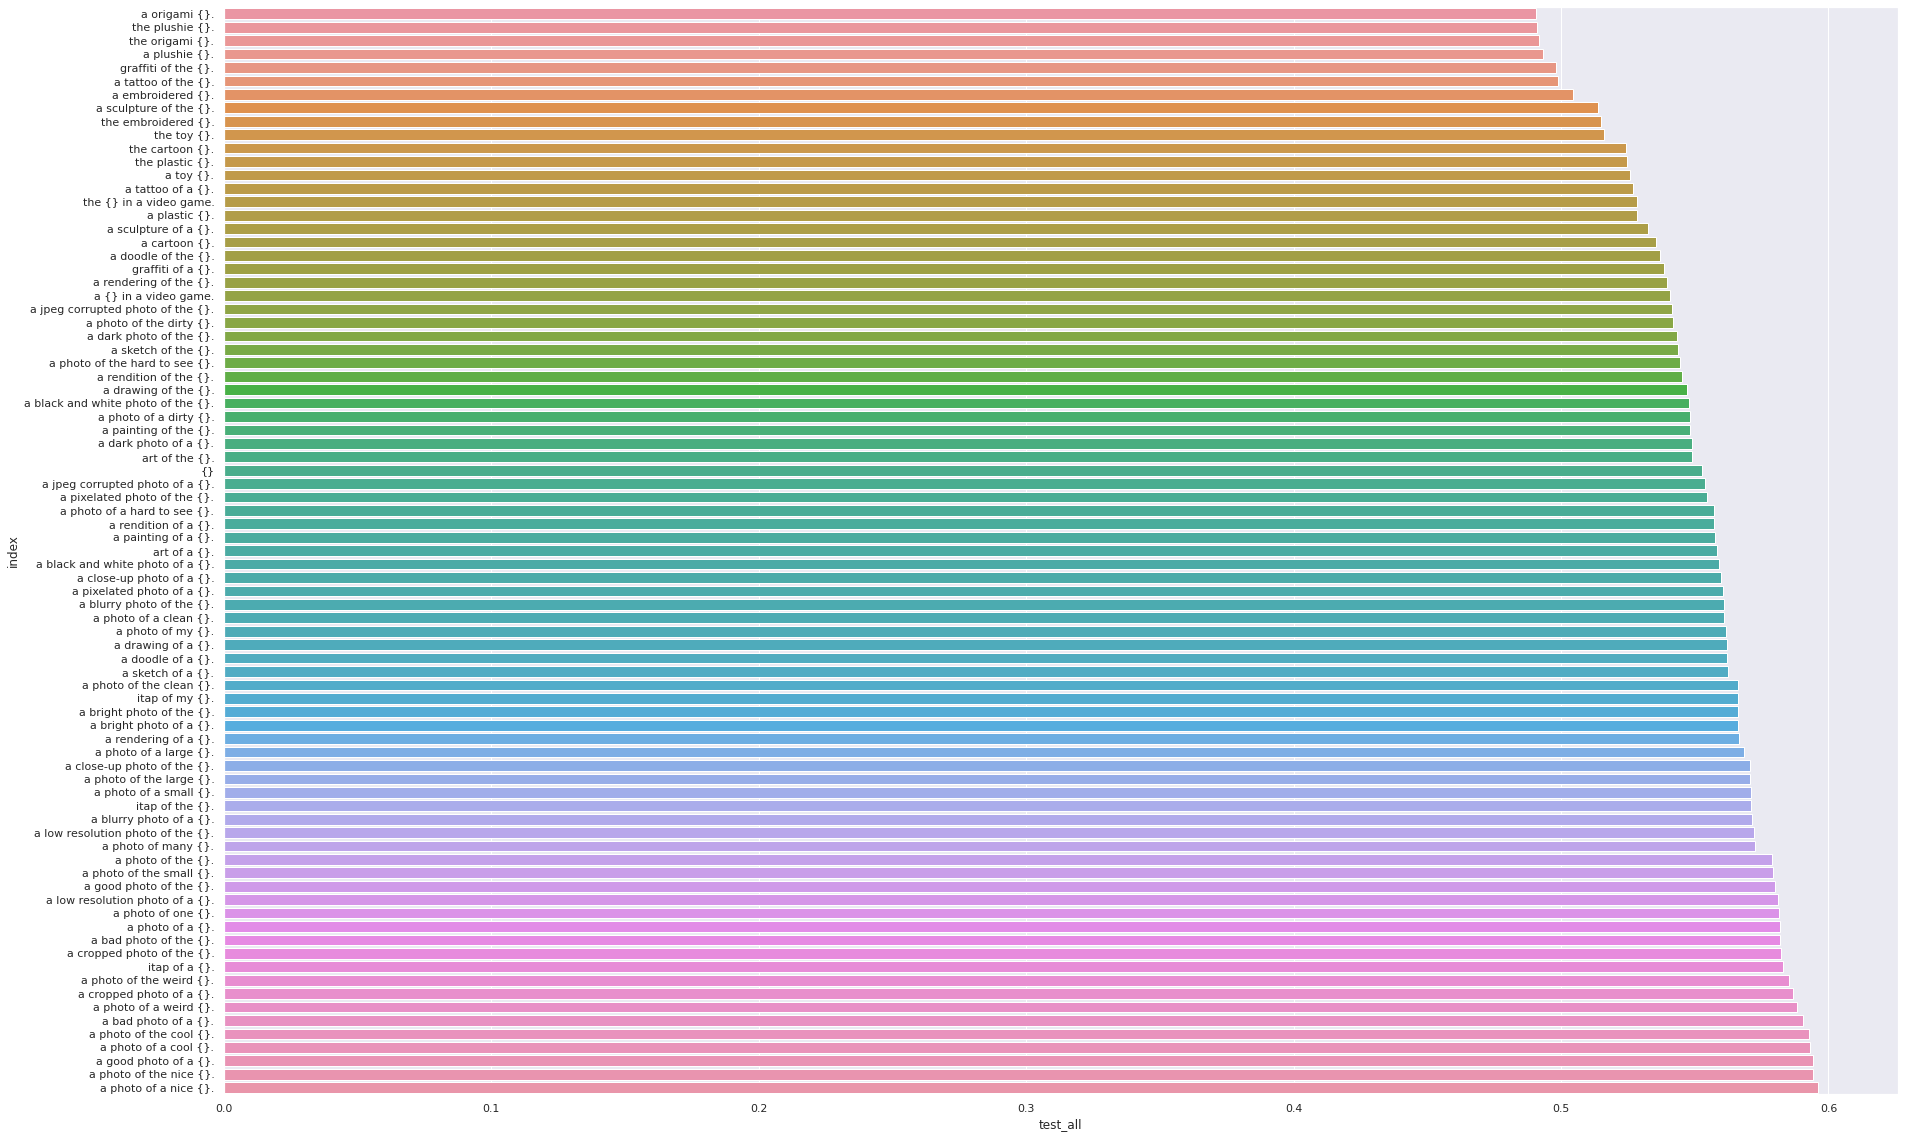

In [28]:
ax = sns.barplot(y="index",x="test_all", data=df)
sns.set(rc={'figure.figsize':(30,20)})
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
# ax.set_yticklabels(ax.get_yticklabels())


In [33]:
best_prompts=list(df["index"][-15:])
best_prompts

['a low resolution photo of a {}.',
 'a photo of one {}.',
 'a photo of a {}.',
 'a bad photo of the {}.',
 'a cropped photo of the {}.',
 'itap of a {}.',
 'a photo of the weird {}.',
 'a cropped photo of a {}.',
 'a photo of a weird {}.',
 'a bad photo of a {}.',
 'a photo of the cool {}.',
 'a photo of a cool {}.',
 'a good photo of a {}.',
 'a photo of the nice {}.',
 'a photo of a nice {}.']

Visualizing the clustering of images and prompts

In [41]:
from classes import *
import json
import pathlib
import os
import sys  
sys.path.insert(0, '/nethome/bdevnani3/flash1/long_tail_lang/')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from os import listdir
from os.path import isfile, join
from clip import clip
from data_loader import dataloaders as dataloader

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('RN50', device)

In [153]:
# class_index = 15 # low
# class_index = 5 # med
class_index = 1 # high
# class_index = 55 # high

In [154]:
text_data = []
labels = []

actual_label = CLASSES[class_index]
print("*****", actual_label, "*****")

for i, prompt in enumerate(GENERIC_PROMPT_COLLECTIONS["ImageNet"]):
    with torch.no_grad():
        text = clip.tokenize(prompt.format(actual_label))
        text_inputs = text.cuda()
        text_features = model.encode_text(text_inputs)
        text_data.append(text_features)
        labels.append(class_index)

text_data = torch.cat(text_data)
text_data = text_data / text_data.norm(
    dim=-1, keepdim=True
)
text_data.shape

***** goldfish *****


torch.Size([82, 1024])

In [155]:
actual_label = CLASSES[class_index]
print("*****", actual_label, "*****")

image_data = []

d, freqs = dataloader.load_data(
    data_root="../datasets/ImageNet/",
    dataset="ImageNet_LT",
    phase="train",
    batch_size=1,
    num_workers=4,
    shuffle=False,
)


***** goldfish *****
Loading data from /nethome/bdevnani3/flash1/long_tail_lang/data/ImageNet_LT/ImageNet_LT_train.txt
Use data transformation: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.5, 1), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
    ToTensor()
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
)
train 115846
No sampler.
Shuffle is False.


In [138]:
for i in freqs:
    if freqs[i] > 100:
        print(i, freqs[i])

1 250
2 516
3 352
4 143
8 150
14 121
16 232
18 392
19 157
21 181
22 177
23 171
24 114
26 134
28 279
29 248
30 287
34 118
42 236
43 103
46 346
48 201
50 376
52 189
55 157
57 173
61 150
67 297
68 349
72 428
74 137
80 126
83 135
84 226
85 281
86 1280
89 502
90 186
93 222
97 819
103 111
106 116
107 133
108 128
112 393
114 179
115 124
117 604
119 240
121 148
126 246
129 161
131 370
132 197
133 155
134 285
137 178
147 105
148 189
150 126
156 245
161 119
168 112
172 272
173 469
174 150
176 199
177 137
182 367
191 244
192 305
194 106
201 214
205 125
206 110
207 119
212 114
213 171
219 496
224 117
229 138
235 281
240 126
241 127
244 172
245 119
247 163
250 181
253 167
257 282
261 137
262 102
269 132
270 303
272 167
276 187
278 310
279 137
280 241
281 123
284 186
296 330
302 208
304 566
309 306
311 119
315 143
318 611
319 290
320 170
321 114
325 128
327 332
329 446
331 122
333 1121
335 109
336 133
338 174
340 283
341 140
345 134
346 167
347 198
348 149
350 122
352 194
353 149
355 156
357 127
361

In [156]:
for inp, label, _, _ in tqdm(d):
    if len(image_data) >= 1:
        break
    if int(label) == int(class_index):
        print(len(image_data))
        with torch.no_grad():
            image_features = model.encode_image(inp.cuda())
            image_data.append(image_features)

image_data = torch.cat(image_data)
image_data = image_data / image_data.norm(
    dim=-1, keepdim=True
)
image_data.shape

  0%|          | 0/115846 [00:00<?, ?it/s]

0


torch.Size([1, 1024])

In [157]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0,
            perplexity=50,
            learning_rate="auto",
            n_iter=5000,)



In [158]:
weighted_add = 0.75*image_data + 0.25*text_data[1]

In [159]:
embeddings_2 = torch.cat((text_data, image_data, weighted_add))
print(embeddings.shape)
# embeddings2d = tsne.fit_transform(embeddings.cpu())
# print(embeddings2d.shape)
embeddings2d_4 = tsne.fit_transform(embeddings.cpu())
print(embeddings2d_4.shape)

torch.Size([242, 1024])


/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


(242, 2)


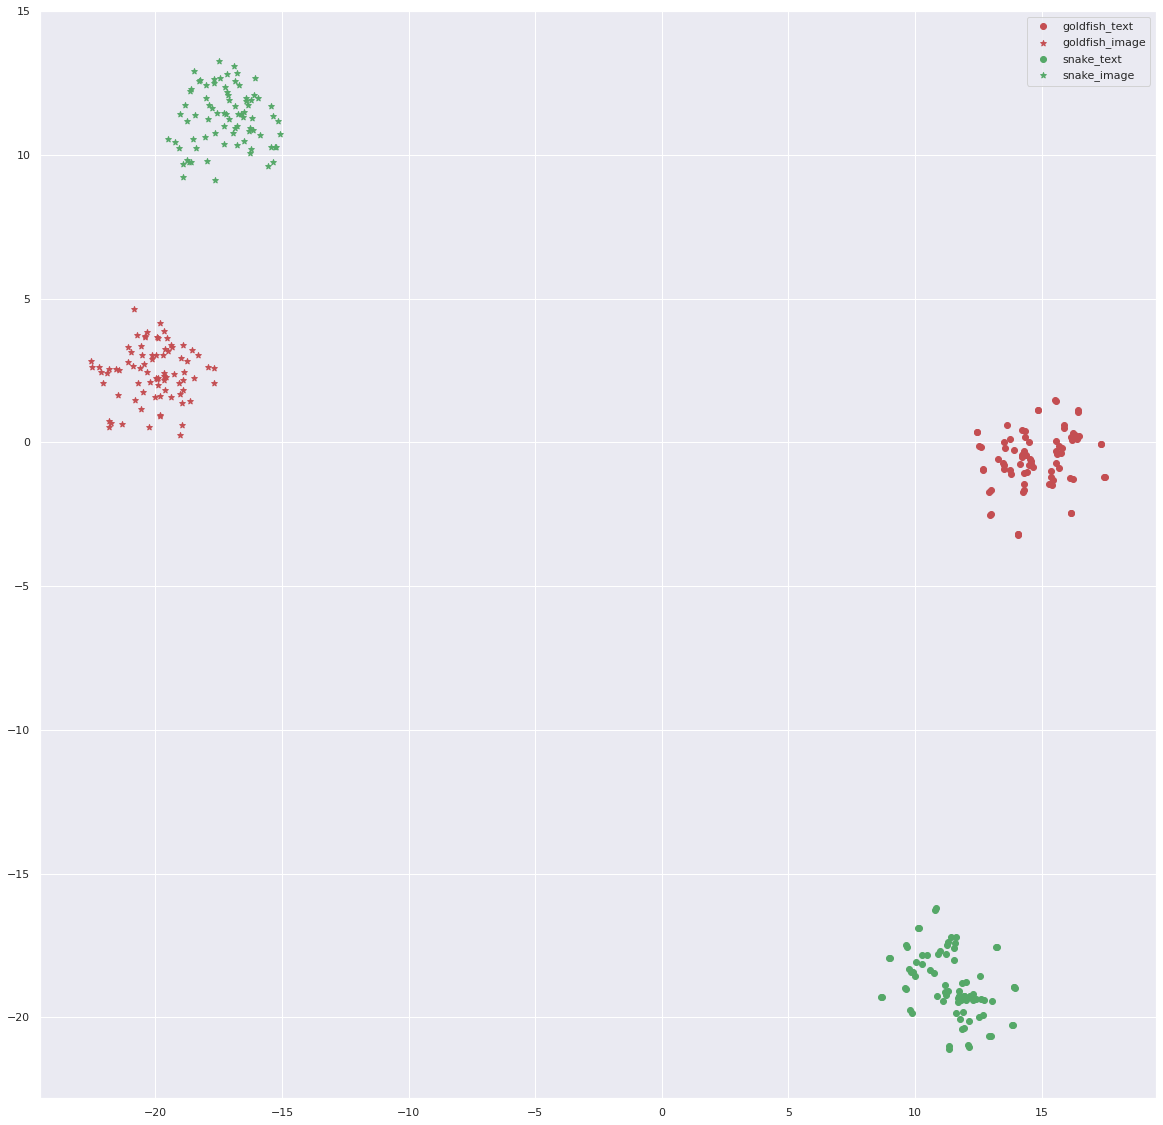

In [118]:
# Set figsize
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(embeddings2d[:82,0], embeddings2d[:82,1], c="r", label="goldfish_text")
ax.scatter(embeddings2d[82:,0], embeddings2d[82:,1], c="r", marker="*", label="goldfish_image")
ax.scatter(embeddings2d_2[:82,0], embeddings2d_2[:82,1], c="g", label="snake_text")
ax.scatter(embeddings2d_2[82:,0], embeddings2d_2[82:,1], c="g", marker="*", label="snake_image")
ax.legend()

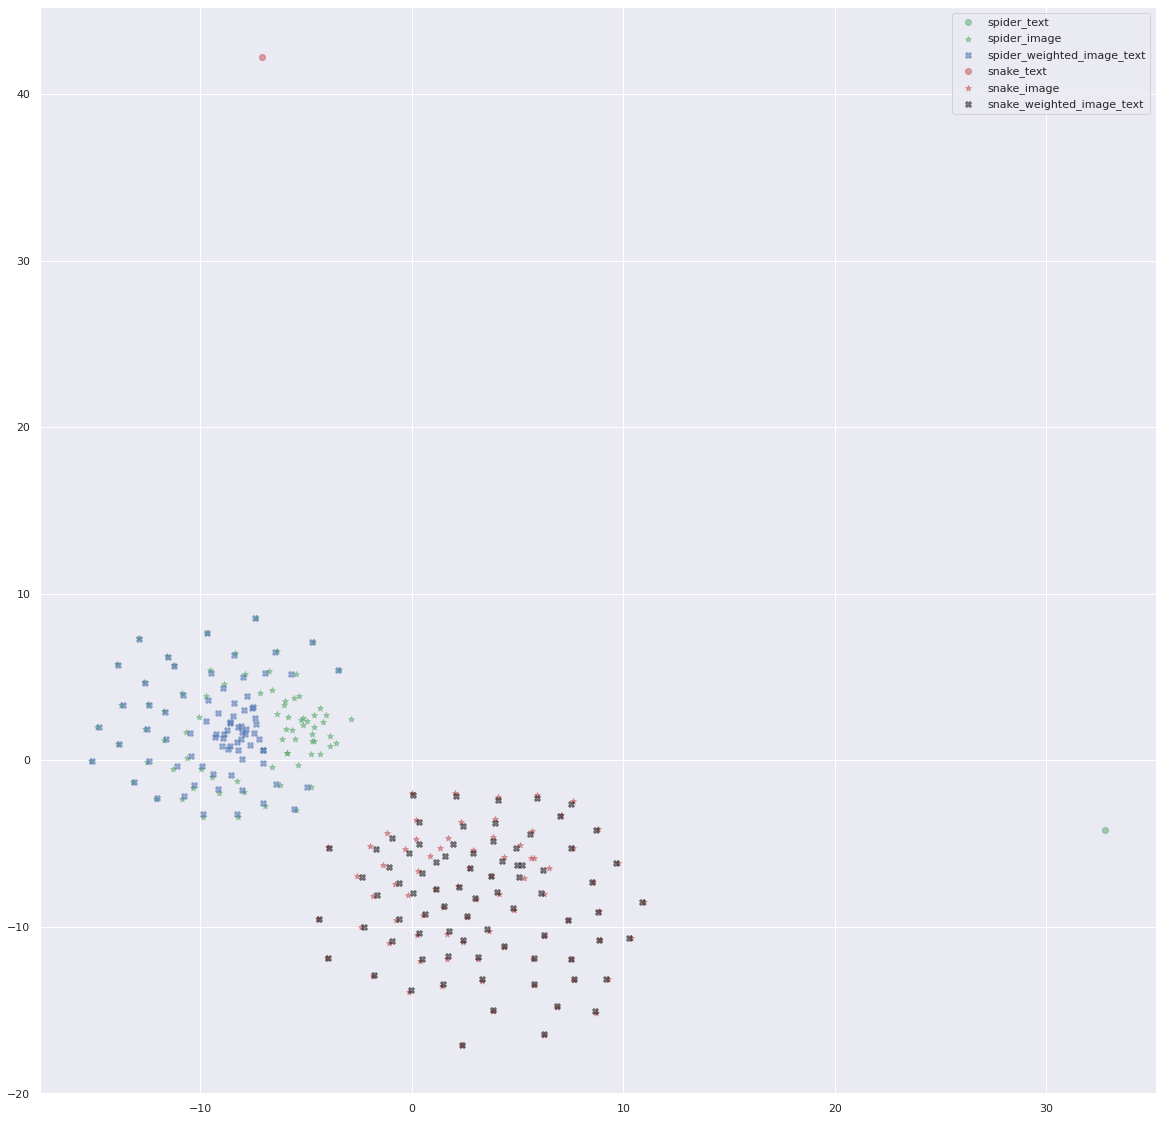

In [150]:
# Set figsize
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(embeddings2d_3[1,0], embeddings2d_3[1,1], c="g", label="spider_text", alpha=0.5)
ax.scatter(embeddings2d_3[82:162,0], embeddings2d_3[82:162,1], c="g", marker="*", label="spider_image", alpha=0.5)
ax.scatter(embeddings2d_3[162:,0], embeddings2d_3[162:,1], c="b",  marker="X", label="spider_weighted_image_text", alpha=0.5)

ax.scatter(embeddings2d_4[1,0], embeddings2d_4[1,1], c="r", label="snake_text", alpha=0.5)
ax.scatter(embeddings2d_4[82:162,0], embeddings2d_4[82:162,1], c="r", marker="*", label="snake_image", alpha=0.5)
ax.scatter(embeddings2d_4[162:,0], embeddings2d_4[162:,1], c="k",  marker="X", label="snake_weighted_image_text", alpha=0.5)
ax.legend()

In [162]:
# embeddings.shape (82, 80, 80)
im1 = embeddings[84]
t1 = embeddings[1]

In [164]:
# embeddings_2.shape (82, 1, 1)
im2 = embeddings_2[83]
t2 = embeddings_2[1]

In [166]:
# im1 t1
dis1 = torch.dot(im1,t1)
dis1

tensor(0.2233, device='cuda:0', dtype=torch.float16)

In [168]:
dis2 = torch.dot(im2,t2)
dis2

tensor(0.4070, device='cuda:0', dtype=torch.float16)

In [169]:
dis3 = torch.dot(im1,t2)
dis3

tensor(0.1473, device='cuda:0', dtype=torch.float16)

In [170]:
dis3 = torch.dot(im2,t1)
dis3

tensor(0.2306, device='cuda:0', dtype=torch.float16)